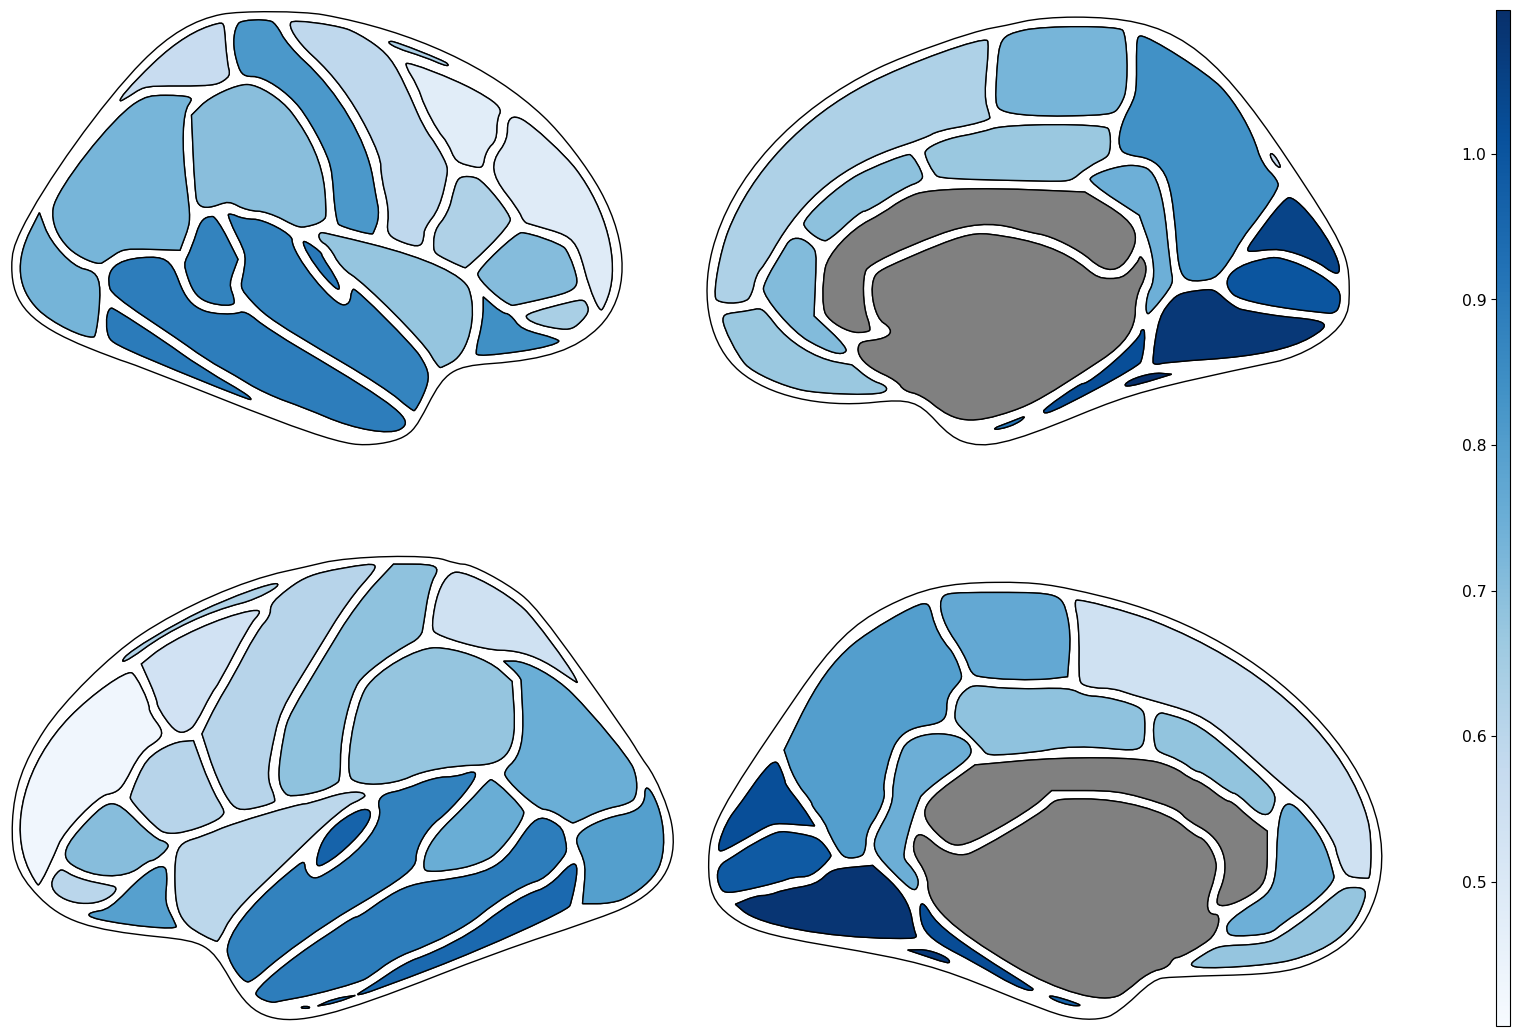

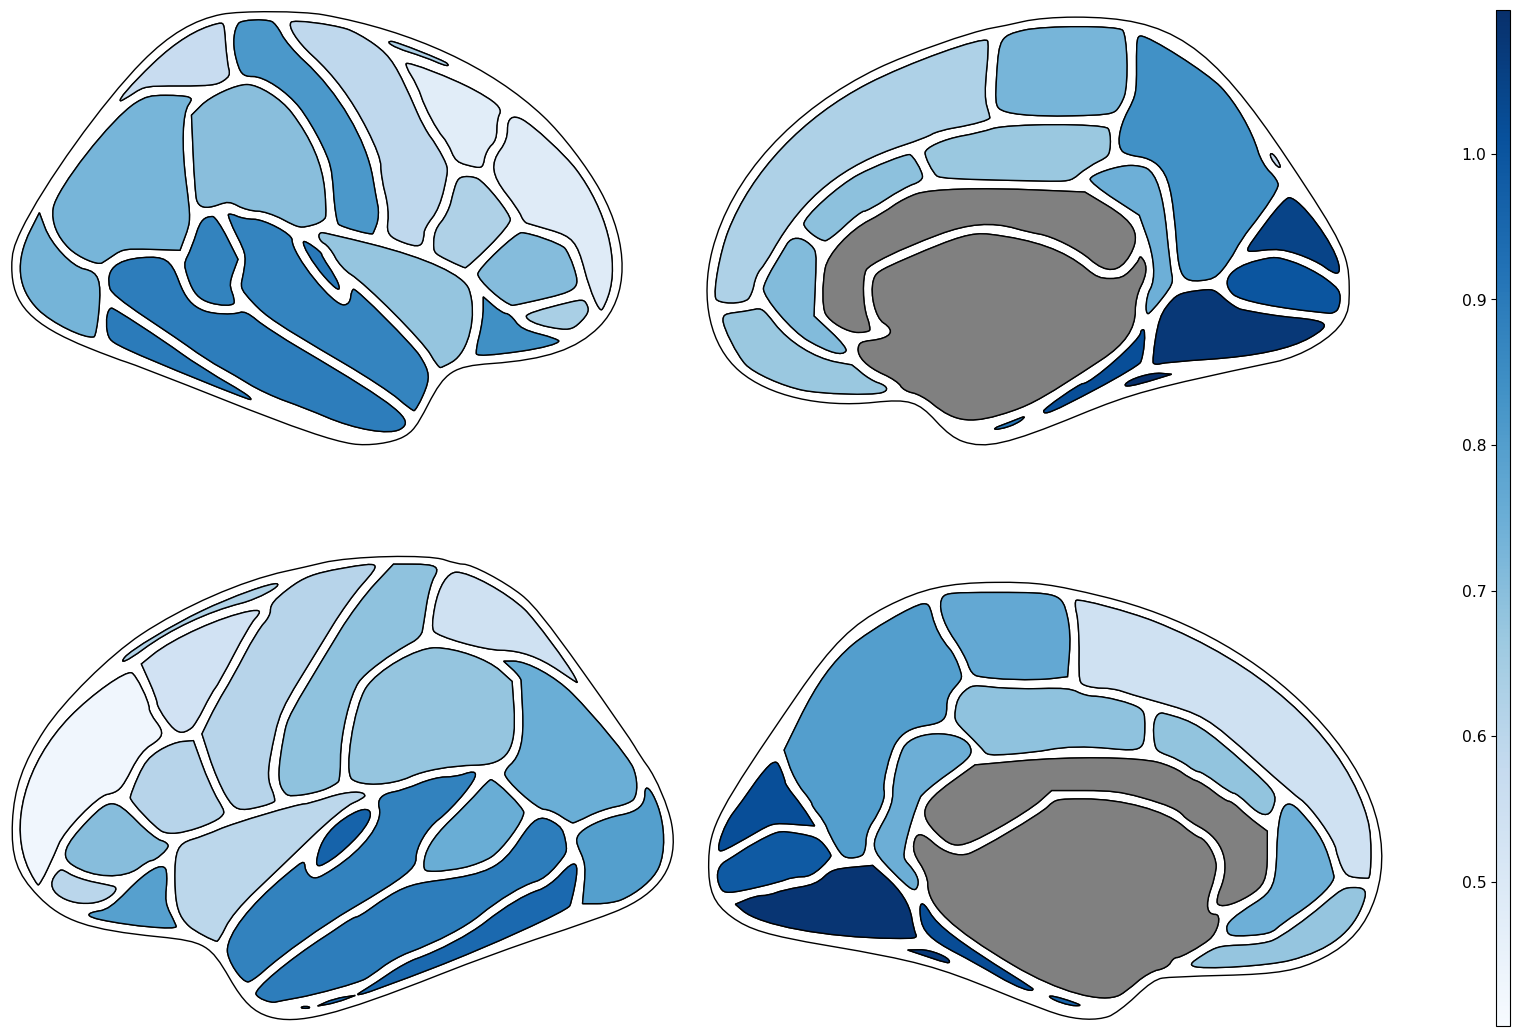

In [1]:
import pandas as pd
import ggseg


DATA_FOLDER = "../../data"
OUTPUT_FOLDER = f"{DATA_FOLDER}/OUTPUT"

df = pd.read_csv(f'{OUTPUT_FOLDER}/specparam_values_2023-05-19.csv')
# display(df.head())


def compute_group(df: pd.DataFrame, group: str):
    dx = (df
          .loc[df['type'] == "real"]
          .drop(columns=['CF', 'PW', "BW", "session", "type"])
          .drop_duplicates()
          .assign(labels_atlas=lambda x: x.labels.str.replace('L', 'left').str.replace('R', 'right').str.replace(' ', '_'))
          .reset_index(drop=True)
          .groupby(["labels_atlas"])
          .mean("exponent")
          .reset_index(drop=False)

          )
    data_dx = dict(zip(dx.labels_atlas, dx.exponent))
    ggseg.plot_dk(data_dx, background='w', edgecolor='k', cmap='Blues')
    return dx


df_real = compute_group(df, "real")
df_real = compute_group(df, "sham")


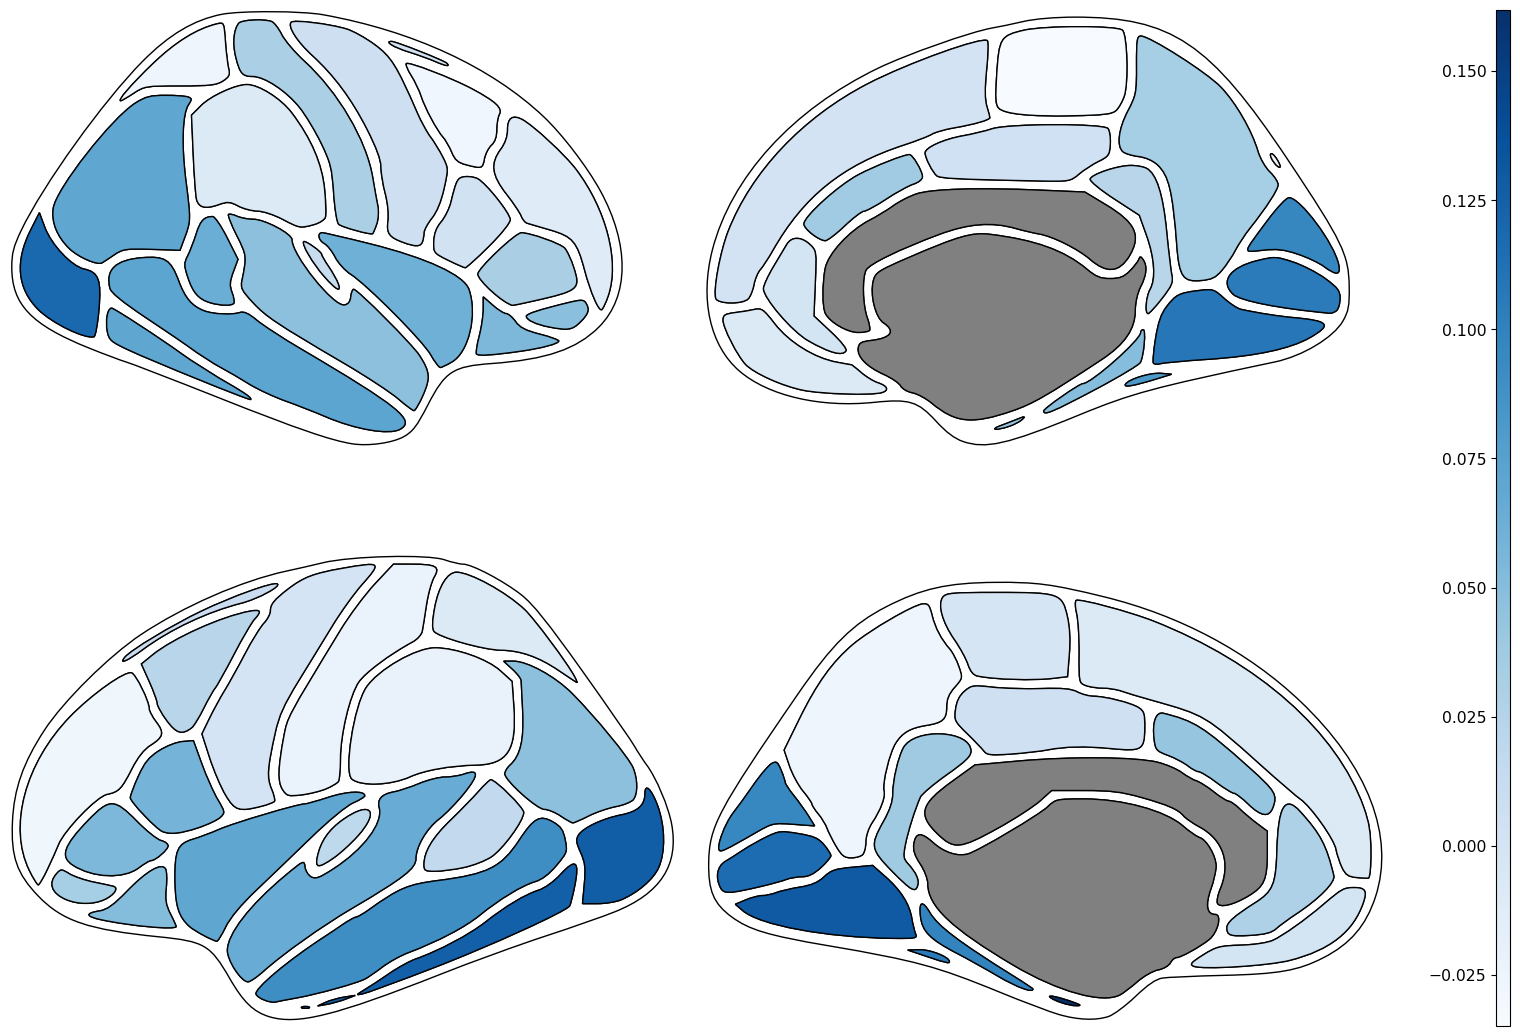

In [2]:
def compute_difference(df: pd.DataFrame):
    # Calculate mean for 'real' type
    real_df = (df.loc[df['type'] == "real"]
               .drop(columns=['CF', 'PW', "BW", "session", "type"])
               .drop_duplicates()
               .assign(labels_atlas=lambda x: x.labels.str.replace('L', 'left').str.replace('R', 'right').str.replace(' ', '_'))
               .groupby("labels_atlas")["exponent"].mean())

    # Calculate mean for 'sham' type
    sham_df = (df.loc[df['type'] == "sham"]
               .drop(columns=['CF', 'PW', "BW", "session", "type"])
               .drop_duplicates()
               .assign(labels_atlas=lambda x: x.labels.str.replace('L', 'left').str.replace('R', 'right').str.replace(' ', '_'))
               .groupby("labels_atlas")["exponent"].mean())

    # Compute difference
    diff_df = real_df - sham_df

    return diff_df.reset_index()


diff = compute_difference(df)
data_dx = dict(zip(diff.labels_atlas, diff.exponent))
ggseg.plot_dk(data_dx, background='w', edgecolor='k', cmap='Blues')


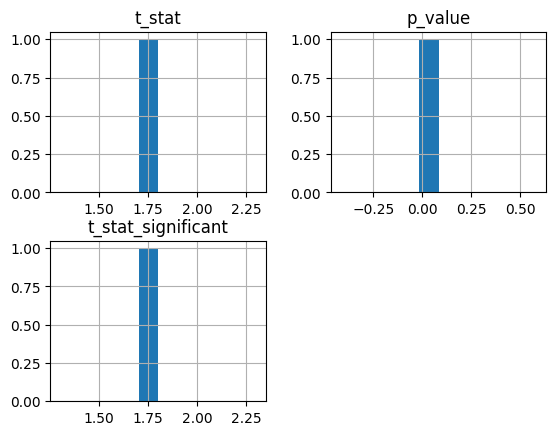

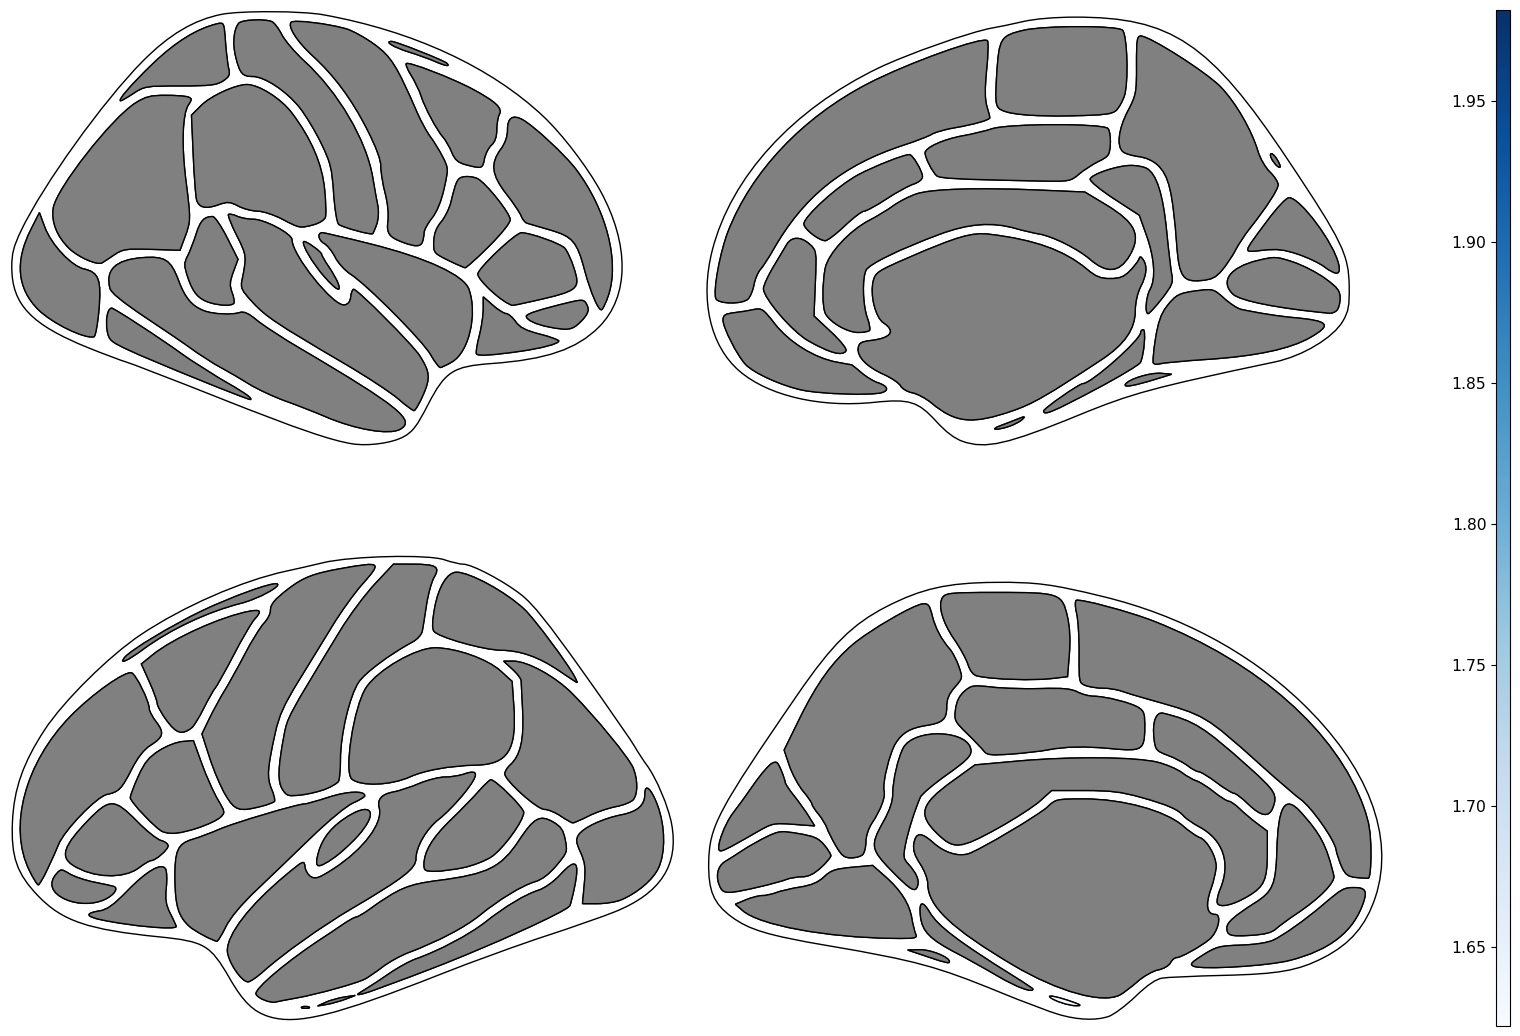

In [3]:
from scipy import stats
import numpy as np

def compute_ttest(df: pd.DataFrame):

    df = (
        df
        .drop(columns=['CF', 'PW', "BW", "session"])
        .drop_duplicates()
        .assign(labels_atlas=lambda x: x.labels.str.replace('L', 'left').str.replace('R', 'right').str.replace(' ', '_'))
    )
    labels = df.labels_atlas.unique()

    result = []

    for label in labels:
        real_df = (df.loc[(df['type'] == "real") & (
            df['labels_atlas'] == label), 'exponent'])
        sham_df = (df.loc[(df['type'] == "sham") & (
            df['labels_atlas'] == label), 'exponent'])

        # Compute t-test
        t_stat, p_value = stats.ttest_ind(
            real_df, sham_df, equal_var=False, nan_policy='omit')

        result.append({
            'labels_atlas': label,
            't_stat': t_stat,
            'p_value': p_value,
        })
    threshold = 0.1
    result_df = pd.DataFrame(result)
    result_df['t_stat_significant'] = result_df.apply(lambda row: row['t_stat'] if row['p_value'] < threshold else np.nan, axis=1)

    return result_df


diff = compute_ttest(df).dropna()
diff.hist()
data_dx = dict(zip(diff.labels_atlas, diff.t_stat_significant))
ggseg.plot_dk(data_dx, background='w', edgecolor='k', cmap='Blues')


# Load example data and plot it on Desikan-Killyany atlas

# Specific parcelation

The parcelation that was use is Desikan-Killiany atlas(Destrieux et al., 2010) with 68 regions. The atlas was obtained from `nilearn` package(Abraham et al., 2014).

[python-ggseg/ggseg.ipynb at main · danieltomasz/python-ggseg · GitHub](https: // github.com/danieltomasz/python-ggseg/blob/main/doc/ggseg.ipynb)
